In [132]:
import boto3
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, auc
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler

plt.style.use("default")
# sns.set_theme(style="white")


load_dotenv()

LOCAL_DIR = "data"

In [133]:
os.listdir(LOCAL_DIR)

['feature_frame.parquet']

In [3]:

bb_df = pd.read_parquet("data/feature_frame.parquet", engine="fastparquet")

In [4]:
bb_df.variant_id.nunique()

976

In [5]:
info_cols = ["variant_id","order_id","user_id","created_at","order_date"]
label_col = "outcome"
feature_cols = [col for col in bb_df.columns if col not in info_cols + [label_col]]

categorical_cols = ["product_type","vendor"]
binary_cols = ["ordered_before","abandoned_before","active_snoozed","set_as_regular"]
numerical_cols = [col for col in feature_cols if col not in categorical_cols + binary_cols]

In [6]:
bb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [7]:
bb_df[["variant_id","order_id","outcome"]].head()

,variant_id,order_id,outcome
0,33826472919172,2807985930372,0.0
1,33826472919172,2808027644036,0.0
2,33826472919172,2808099078276,0.0
3,33826472919172,2808393957508,0.0
4,33826472919172,2808429314180,0.0


In [8]:
(
    bb_df.groupby("order_id")["user_id"]
    .nunique()
    .reset_index()
)["user_id"].unique()

array([1])

In [9]:
(
    bb_df.groupby("order_id")["user_id"]
    .nunique() > 1
    ).any()

False

Con esto vemos que la relación entre "order_id" y "user_id" es 1:1

In [10]:
(
    bb_df.groupby("user_id")["order_id"]
    .nunique()
    .reset_index()
    ).max()

user_id     5029635227780
order_id               16
dtype: int64

Sin embargo, como es obvio, un usuario puede hacer más de 1 pedido. El usuario "5029635227780" fue el que más pedidos hizo (16 pedidos), aunque luego no comprara

In [11]:
user = 5029635227780
(bb_df.loc[lambda df:df["user_id"] == user].outcome == 1).sum()

2

Únicamente compró dos ítems

<Axes: xlabel='order_id'>

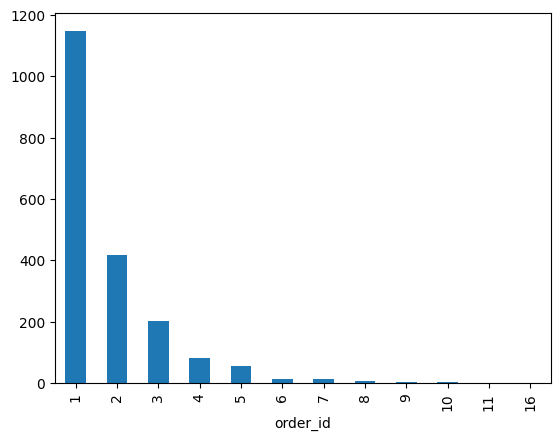

In [12]:
(
    bb_df.groupby("user_id")["order_id"]
    .nunique()
    .reset_index()
)["order_id"].value_counts().sort_index().plot(kind="bar")

In [13]:
filtered_orders = ( 
    bb_df.groupby(["order_id"])["outcome"]
    .sum()
    .reset_index()
    .loc[lambda df:df["outcome"].ge(5)] 
)["order_id"]

filtered_orders

0       2807985930372
1       2808027644036
2       2808099078276
3       2808393957508
5       2808434524292
            ...      
3438    3643241300100
3441    3643254800516
3442    3643274788996
3443    3643283734660
3444    3643294515332
Name: order_id, Length: 2603, dtype: int64

In [14]:
filtered_df = bb_df.loc[lambda df:df["order_id"].isin(filtered_orders)].copy()
filtered_df.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
5,33826472919172,ricepastapulses,2808434524292,3479090790532,2020-10-06 10:50:23,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [15]:
# Otra forma de hacerlo (como lo hace Guille en la corrección) con el método .pipe()

def push_relevant_dataframe(df: pd.DataFrame, min_products: int = 5) -> pd.DataFrame:
    order_size = df.groupby("order_id").outcome.sum()
    orders_of_min_size = order_size[order_size >= min_products].index
    return df.loc[lambda x: x.order_id.isin(orders_of_min_size)]

def format_date_columns(df: pd.DataFrame) -> pd.DataFrame:
    return (
        df
        .assign(created_at=lambda x: pd.to_datetime(x.created_at))
        .assign(order_date=lambda x: pd.to_datetime(x.order_date).dt.date)
    )

filtered_df = (
    bb_df
    .pipe(push_relevant_dataframe)
    .pipe(format_date_columns)
)

filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2163953 entries, 0 to 2880547
Data columns (total 27 columns):
 #   Column                            Dtype         
---  ------                            -----         
 0   variant_id                        int64         
 1   product_type                      object        
 2   order_id                          int64         
 3   user_id                           int64         
 4   created_at                        datetime64[ns]
 5   order_date                        object        
 6   user_order_seq                    int64         
 7   outcome                           float64       
 8   ordered_before                    float64       
 9   abandoned_before                  float64       
 10  active_snoozed                    float64       
 11  set_as_regular                    float64       
 12  normalised_price                  float64       
 13  discount_pct                      float64       
 14  vendor                 

<Axes: xlabel='product_type'>

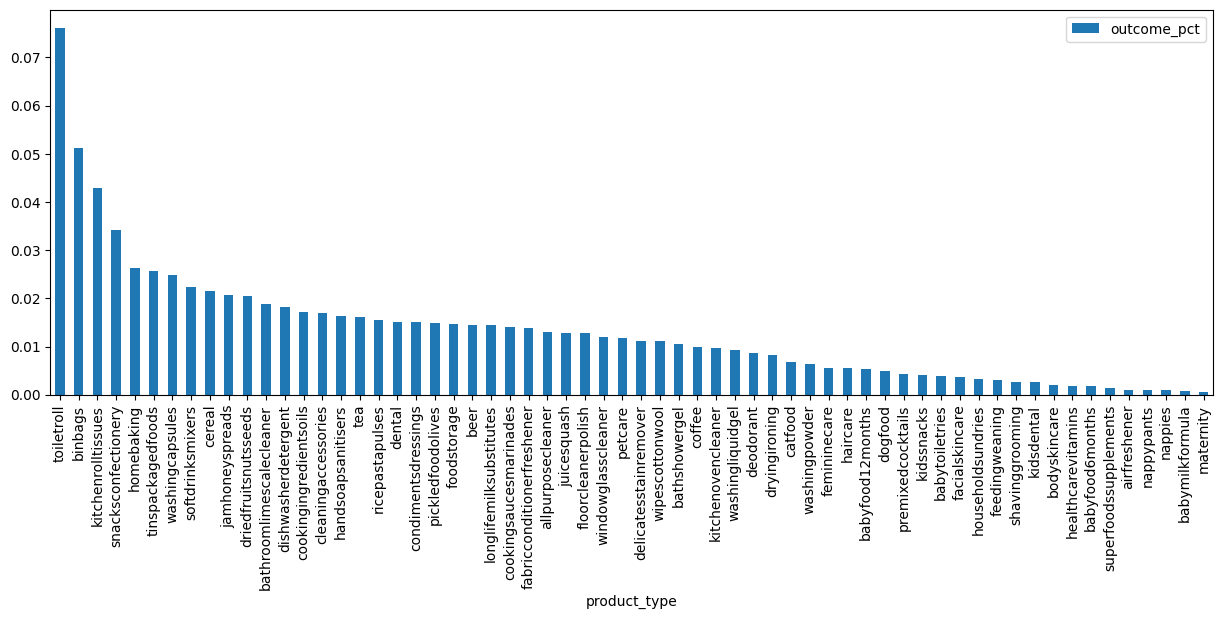

In [16]:
(
    filtered_df.groupby("product_type")["outcome"]
    .mean()
    .reset_index()
    .rename(columns = {"outcome":"outcome_pct"})
    .sort_values("outcome_pct", ascending=False)
    ).plot(kind="bar", x="product_type",figsize=(15,5))

<Axes: xlabel='product_type'>

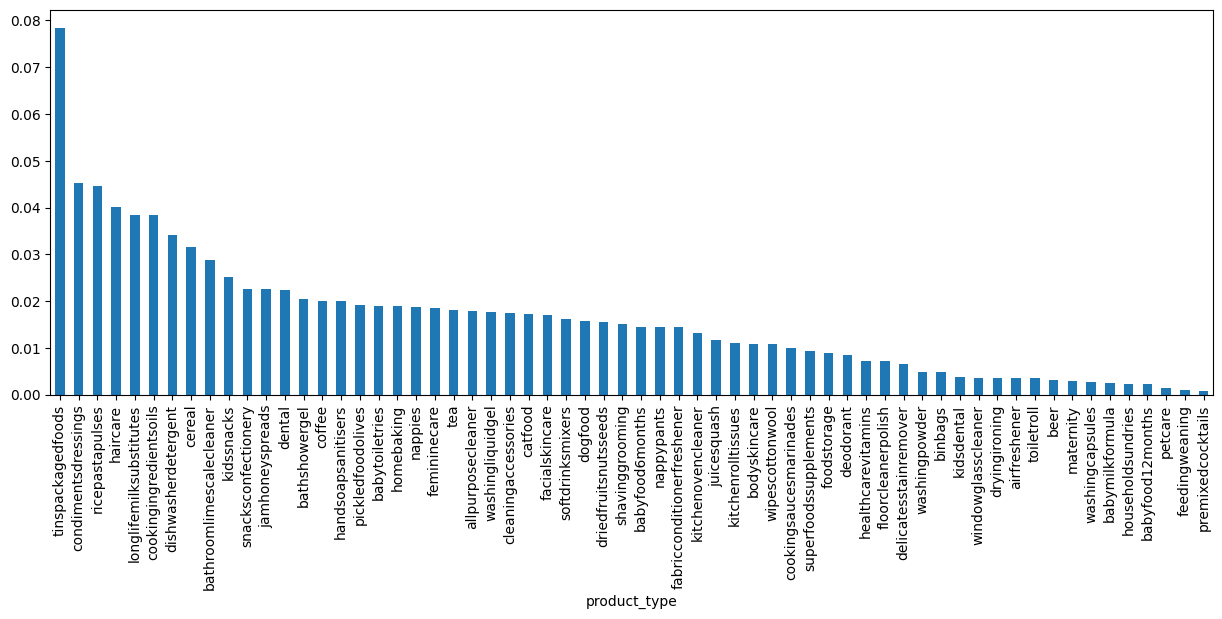

In [17]:
filtered_df.product_type.value_counts(normalize=True).plot(kind="bar",figsize=(15,5))

In [18]:
daily_orders = filtered_df.groupby("order_date").order_id.nunique()
daily_orders.head()


order_date
2020-10-05     3
2020-10-06     7
2020-10-07     6
2020-10-08    12
2020-10-09     4
Name: order_id, dtype: int64

Text(0.5, 1.0, 'Daily orders')

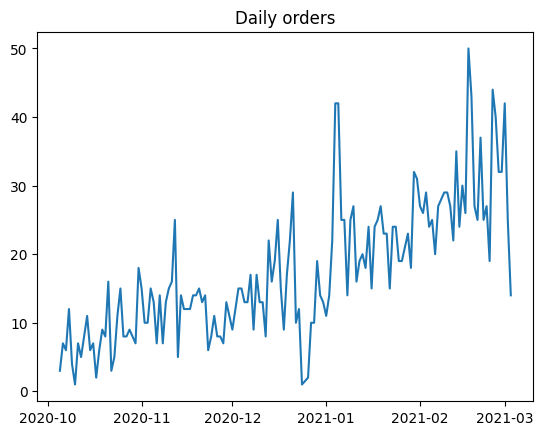

In [19]:
plt.plot(daily_orders, label="daily orders")
plt.title("Daily orders")

- Como se puede comprobar, hay una fuerte evolución temporal en el comportamiento de compra en el negocio, lo que nos viene a decir que las dinámicas de compra de los usuarios varían durante el período estudiado.
En este contexto, lo que tiene más sentido es realizar un **split de datos temporal**, de forma que en el training set no exista información futura y por tanto evitando information leakage.
- Information leakage ocurre cuando le damos al modelo cualquier información que no debería tener, ya que en producción NO la va a tener

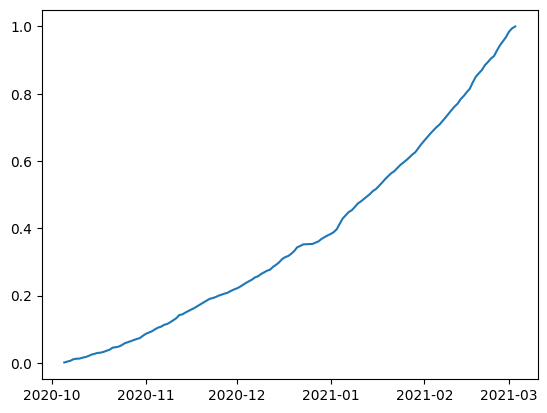

In [20]:
cumsum_daily_orders = daily_orders.cumsum() / daily_orders.sum()
plt.plot(cumsum_daily_orders)

Split temporal:
- Train: 70%
- Val: 20%
- Test: 10%

El split temporal se va a realizar en base al nº de pedidos, pero como esto no es constante en el tiempo, tendremos que hacer el split en base a la **suma acumulada**. Si se hiciera contando el nº de filas que representan el 70% en el df original:
- podríamos tener un train con pocos pedidos (si los primeros días tenían pocos),
- o un train con demasiados pedidos (si los últimos días concentraban muchos).

In [37]:
cumsum_daily_orders[cumsum_daily_orders <= 0.7].idxmax()

datetime.date(2021, 2, 4)

In [22]:
train_val_cutoff = cumsum_daily_orders[cumsum_daily_orders <= 0.7].idxmax()
val_test_cutoff = cumsum_daily_orders[cumsum_daily_orders <= 0.9].idxmax()

In [23]:
train_val_cutoff

datetime.date(2021, 2, 4)

In [38]:
train_df = filtered_df[filtered_df.order_date <= train_val_cutoff]
val_df = filtered_df[
    (filtered_df.order_date > train_val_cutoff) & 
    (filtered_df.order_date <= val_test_cutoff)
    ]
test_df = filtered_df[filtered_df.order_date > val_test_cutoff]
test_df.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type,product_type_freq,vendor_freq
3058,33826472919172,ricepastapulses,2928349577348,3920643883140,2021-02-23 00:05:23,2021-02-23,2,0.0,0.0,0.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,0.044619,0.014435
3059,33826472919172,ricepastapulses,2928554311812,3909597462660,2021-02-23 07:31:17,2021-02-23,2,0.0,0.0,0.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,0.044619,0.014435
3060,33826472919172,ricepastapulses,2928560537732,3879715569796,2021-02-23 07:47:37,2021-02-23,4,0.0,1.0,0.0,...,0.0,2.0,48.0,42.0,31.134053,7.0,30.0,24.27618,0.044619,0.014435
3062,33826472919172,ricepastapulses,2928594518148,3869171810436,2021-02-23 09:24:11,2021-02-23,3,0.0,0.0,0.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,0.044619,0.014435
3063,33826472919172,ricepastapulses,2928611459204,3877728223364,2021-02-23 10:08:29,2021-02-23,3,0.0,0.0,0.0,...,0.0,2.0,33.0,42.0,31.134053,38.0,30.0,24.27618,0.044619,0.014435


In [25]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2163953 entries, 0 to 2880547
Data columns (total 27 columns):
 #   Column                            Dtype         
---  ------                            -----         
 0   variant_id                        int64         
 1   product_type                      object        
 2   order_id                          int64         
 3   user_id                           int64         
 4   created_at                        datetime64[ns]
 5   order_date                        object        
 6   user_order_seq                    int64         
 7   outcome                           float64       
 8   ordered_before                    float64       
 9   abandoned_before                  float64       
 10  active_snoozed                    float64       
 11  set_as_regular                    float64       
 12  normalised_price                  float64       
 13  discount_pct                      float64       
 14  vendor                 

### Baseline

Necesitamos un modelo simple, que ni si quiera requiera ML, que nos sirva de **referencia** para poder evaluar nuestros modelos "inteligentes" (de ML), confirmando que son mejores que la referencia. Podemos tener 1 o varios baselines con los que comparar nuestro modelo de ML

In [39]:
import matplotlib

def plot_metrics(
        model_name: str,
        y_pred: pd.Series,
        y_test: pd.Series,
        target_precision: float = 0.05,
        figure: Tuple[matplotlib.figure.Figure, np.array] = None
):
    precision_, recall_, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall_, precision_)

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    if figure is None:
        fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    else:
        fig, ax = figure
    
    ax[0].plot(recall_, precision_, label=f"{model_name}; AUC: {pr_auc:.2f}")
    ax[0].set_xlabel("recall")
    ax[0].set_ylabel("precision")
    ax[0].set_title("Precision-recall- Curve")
    ax[0].legend()

    ax[1].plot(fpr, tpr, label=f"AUC:{roc_auc:.2f} ")
    ax[1].set_xlabel("FPR")
    ax[1].set_ylabel("TPR")
    ax[1].set_title("ROC curve")
    ax[1].legend()

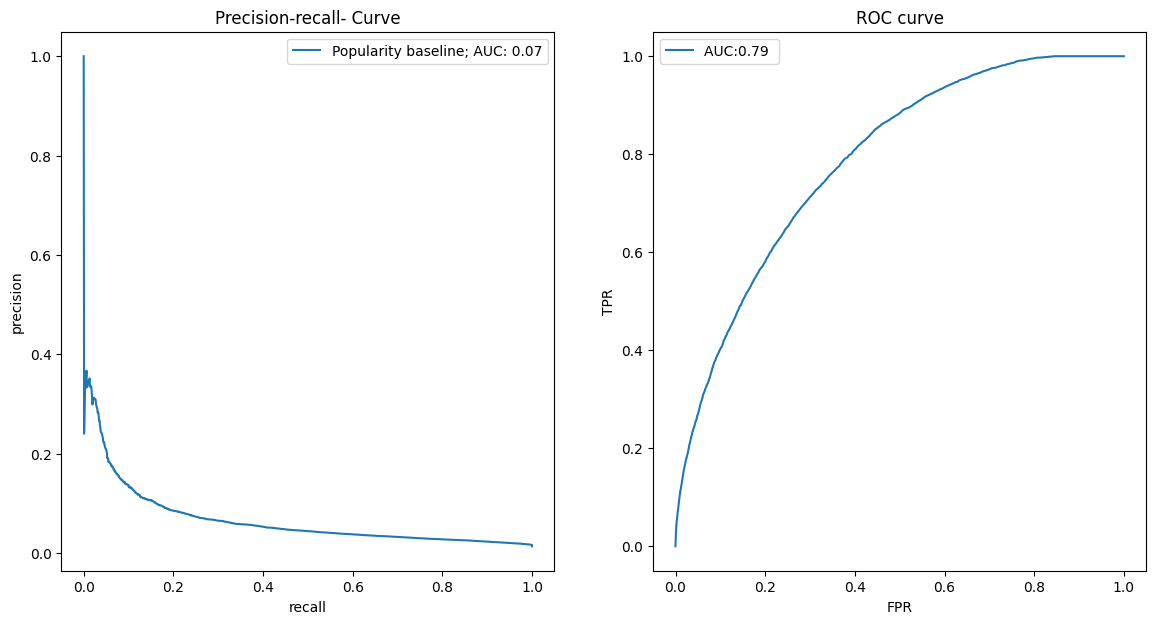

In [28]:
plot_metrics(
    "Popularity baseline", y_pred=val_df["global_popularity"], y_test=val_df[label_col]
)

Correlation plot

In [42]:
def plot_corr_matrix(df: pd.DataFrame):
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(11, 9))

    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Model training

In [63]:
def feature_label_split(
        df: pd.DataFrame, label_col: str
) -> Tuple[pd.DataFrame, pd.Series]:
    X = df.drop(columns=label_col)
    y = df[label_col]
    return X, y

In [64]:
X_train, y_train = feature_label_split(train_df, label_col)
X_val, y_val = feature_label_split(val_df, label_col)
X_test, y_test = feature_label_split(test_df, label_col)

In [72]:
train_cols = numerical_cols + binary_cols

## Ridge regression

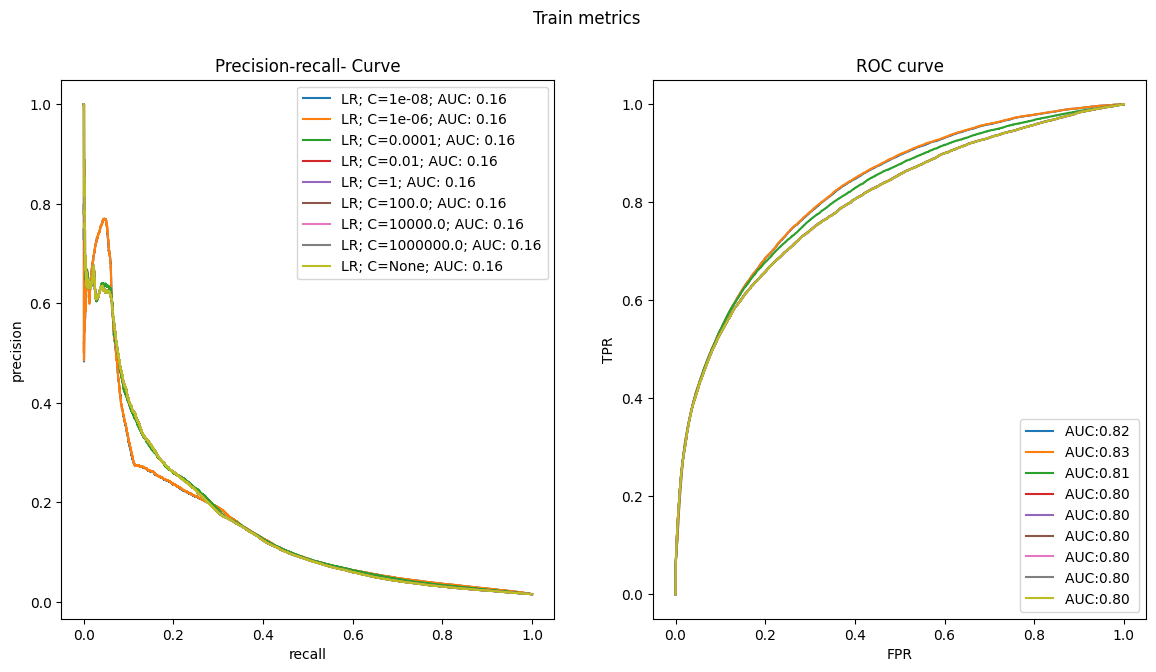

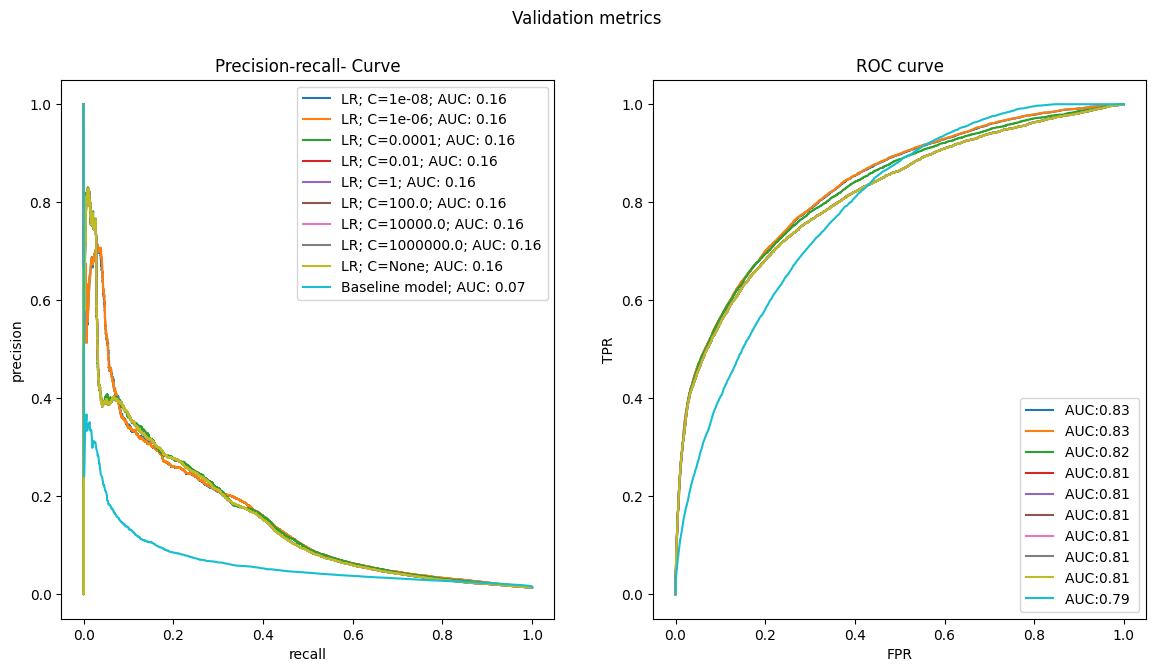

In [82]:
lr_push_train_aucs = []
lr_push_val_aucs = []
lr_push_train_ce = []
lr_push_val_ce = []

fig1, ax1 = plt.subplots(1,2, figsize=(14, 7 ))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1,2, figsize=(14, 7 ))
fig2.suptitle("Validation metrics")

cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 1e2, 1e4, 1e6, None]
for c in cs:
    lr = make_pipeline(
        StandardScaler(), # Z-Score normalization: makes all variables have mean = 0 and std = 1
        LogisticRegression(penalty="l2", C=c if c else 1.0)
    )

    lr.fit(X_train[train_cols], y_train)
    train_proba = lr.predict_proba(X_train[train_cols])[:, 1]
    plot_metrics(
        f"LR; C={c}", y_pred=train_proba, y_test=y_train, figure=(fig1, ax1)
    )

    val_proba = lr.predict_proba(X_val[train_cols])[:, 1]
    plot_metrics(
        f"LR; C={c}", y_pred=val_proba, y_test=y_val, figure=(fig2, ax2)
    ) 

plot_metrics(
    f"Baseline model",
    y_pred=val_df["global_popularity"],
    y_test=val_df[label_col],
    figure=(fig2, ax2)
)                                                   


- La parte izquierda de la curva P-R es muy "rara". Cuando tengo un Recall muy bajo, detecto muy pocos casos positivos lo que significa que el threshold debe de estar demasiado alto. n 

## Lasso Regression

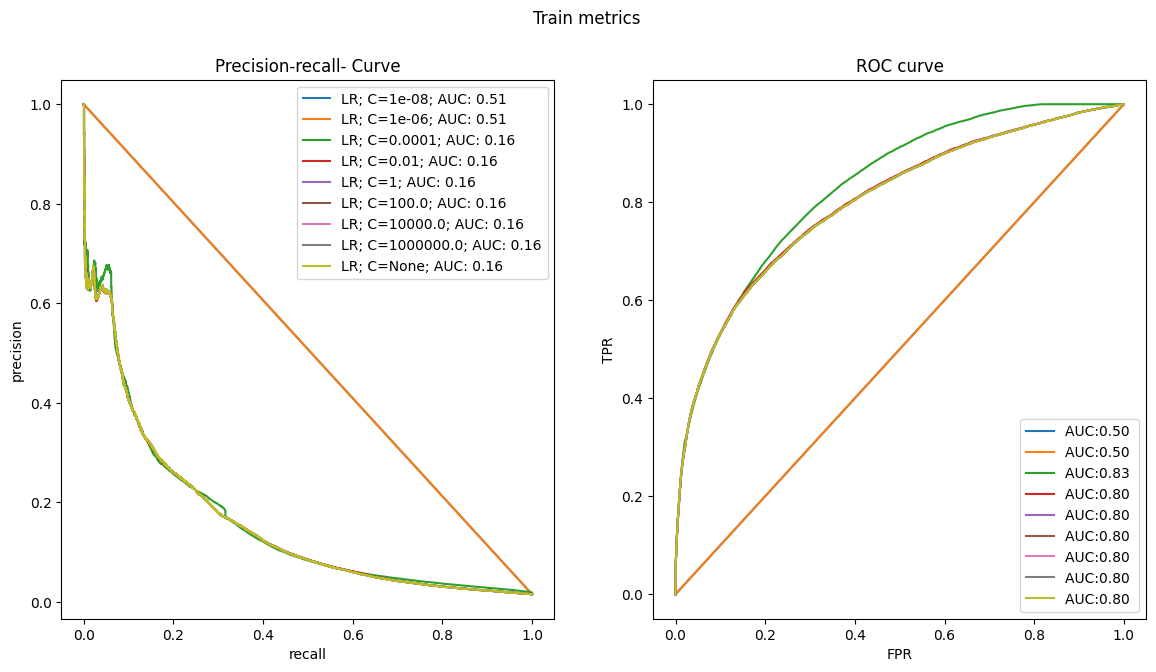

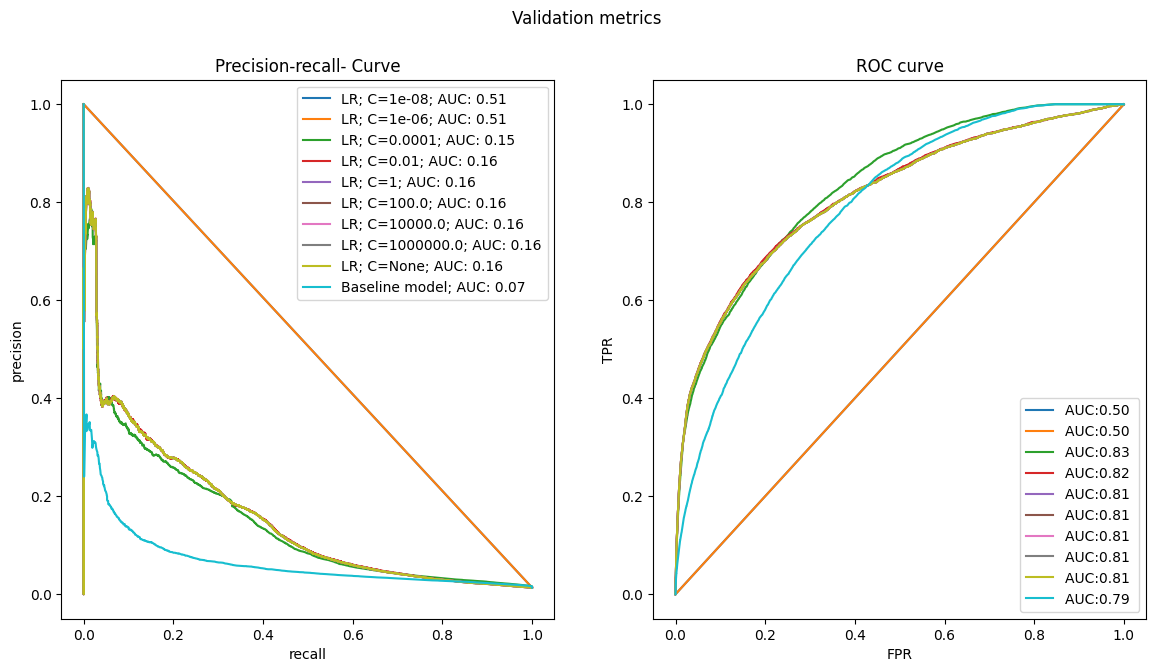

In [84]:
lr_push_train_aucs = []
lr_push_val_aucs = []
lr_push_train_ce = []
lr_push_val_ce = []

fig1, ax1 = plt.subplots(1,2, figsize=(14, 7 ))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1,2, figsize=(14, 7 ))
fig2.suptitle("Validation metrics")

cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 1e2, 1e4, 1e6, None]
for c in cs:
    lr = make_pipeline(
        StandardScaler(), # Z-Score normalization: makes all variables have mean = 0 and std = 1
        LogisticRegression(penalty="l1", solver="saga", C=c if c else 1.0)
    )

    lr.fit(X_train[train_cols], y_train)
    train_proba = lr.predict_proba(X_train[train_cols])[:, 1]
    plot_metrics(
        f"LR; C={c}", y_pred=train_proba, y_test=y_train, figure=(fig1, ax1)
    )

    val_proba = lr.predict_proba(X_val[train_cols])[:, 1]
    plot_metrics(
        f"LR; C={c}", y_pred=val_proba, y_test=y_val, figure=(fig2, ax2)
    ) 

plot_metrics(
    f"Baseline model",
    y_pred=val_df["global_popularity"],
    y_test=val_df[label_col],
    figure=(fig2, ax2)
)   

- La línea recta hace referencia a threshold=0 y threshold=1, esto es, predigo todo como positivos o no predigo nada como positivo.
- No parece haber una mejora significativa con la regularización Lasso, siendo los modelos muy similares a los de Ridge

## Coefficient weights

In [105]:
lr = Pipeline(
    [
        ("standard_scaler", StandardScaler()),
        ("lr", LogisticRegression(penalty="l2", C=1e-6))
    ]
)

lr.fit(X_train[train_cols], y_train)
lr_coeff_l2 = pd.DataFrame(
    {
        "features": train_cols,
        "importance": np.abs(lr.named_steps["lr"].coef_[0]), # Con esto, accedes al objeto LogisticRegression y obtienes los coeficientes con el método "coef_", que representa los pesos de cada feature
        "regularisation": "l2",
    }
)
lr_coeff_l2 = lr_coeff_l2.sort_values("importance", ascending=True)

lr = Pipeline(
    [
        ("standard_scaler", StandardScaler()),
        ("lr", LogisticRegression(penalty="l1", C=1e-4, solver="saga"))
    ]
)

lr.fit(X_train[train_cols], y_train)
lr_coeff_l1 = pd.DataFrame(
    {
        "features": train_cols,
        "importance": np.abs(lr.named_steps["lr"].coef_[0]),
        "regularisation": "l1",
    }
)
lr_coeff_l1 = lr_coeff_l1.sort_values("importance", ascending=True)

<Axes: xlabel='importance', ylabel='features'>

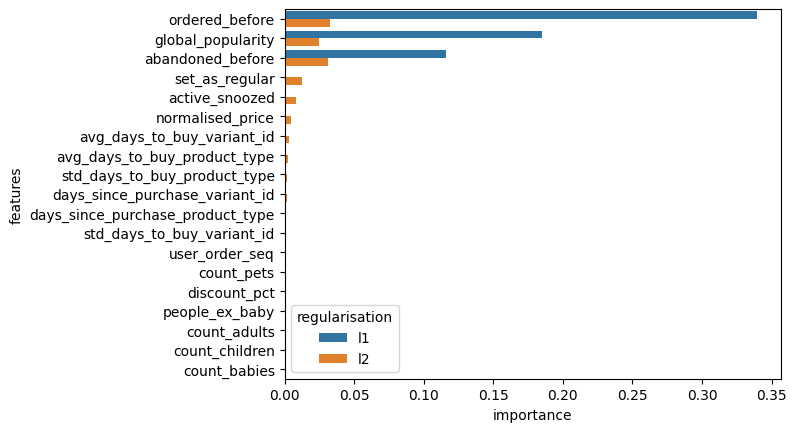

In [127]:
lr_coeffs = pd.concat([lr_coeff_l1, lr_coeff_l2])
lr_coeffs["features"] = pd.Categorical(lr_coeffs["features"])
lr_coeffs = lr_coeffs.sort_values(by="importance")
order_columns = lr_coeffs.sort_values(by="importance", ascending=False)["features"]
sns.barplot(
    data=lr_coeffs,
    x="importance",
    y="features",
    hue="regularisation", # Es como un groupby, en este caso group by "l1" y "l2"
    order=order_columns
)

Como se puede comprobar, según ambas regularizaciones, obtenemos claramente que las features con más "importancia" son:
- `ordered_before`
- `global_popularity`
- `abandoned_before`

La teoría se cumple:
- **Lasso**: se obtienen soluciones "sparse", lo que quiere decir que lleva la mayoría de pesos a 0
- **Ridge**: propone soluciones en la que todos los pesos son más pequeños, ya que estamos penalizando el cuadrado

## Feature selection

En base al análisis anterior, reentrenamos el modelo únicamente con las variables "importantes":
- `ordered_before`
- `global_popularity`
- `abandoned_before`

In [129]:
new_train_cols = ["ordered_before", "global_popularity", "abandoned_before"]

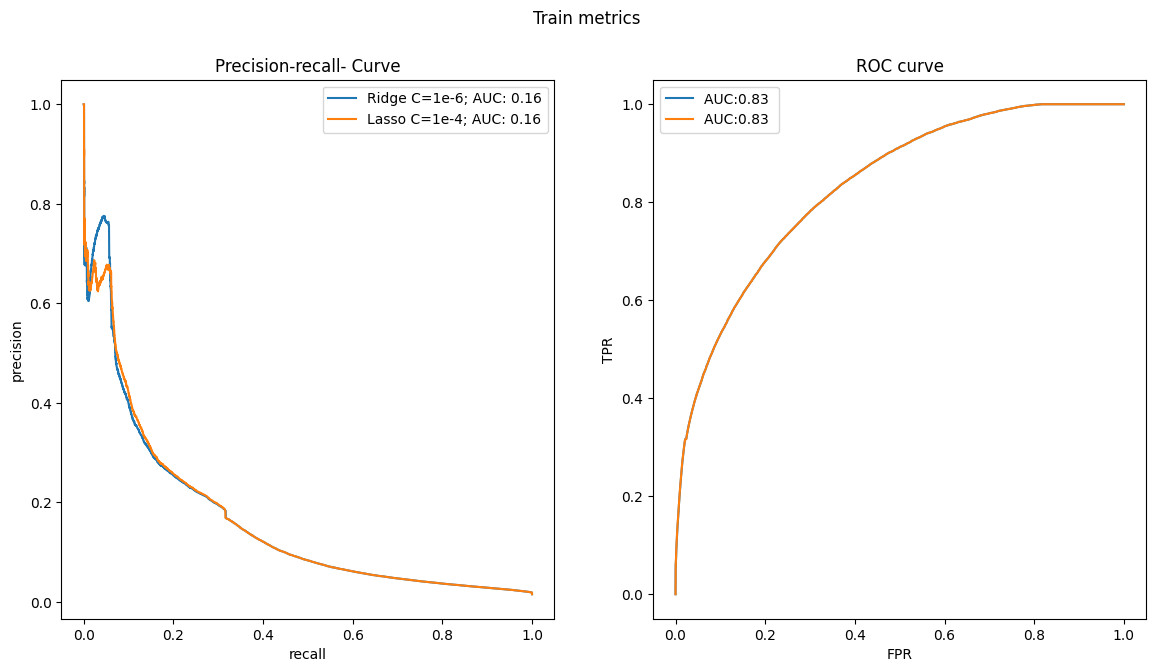

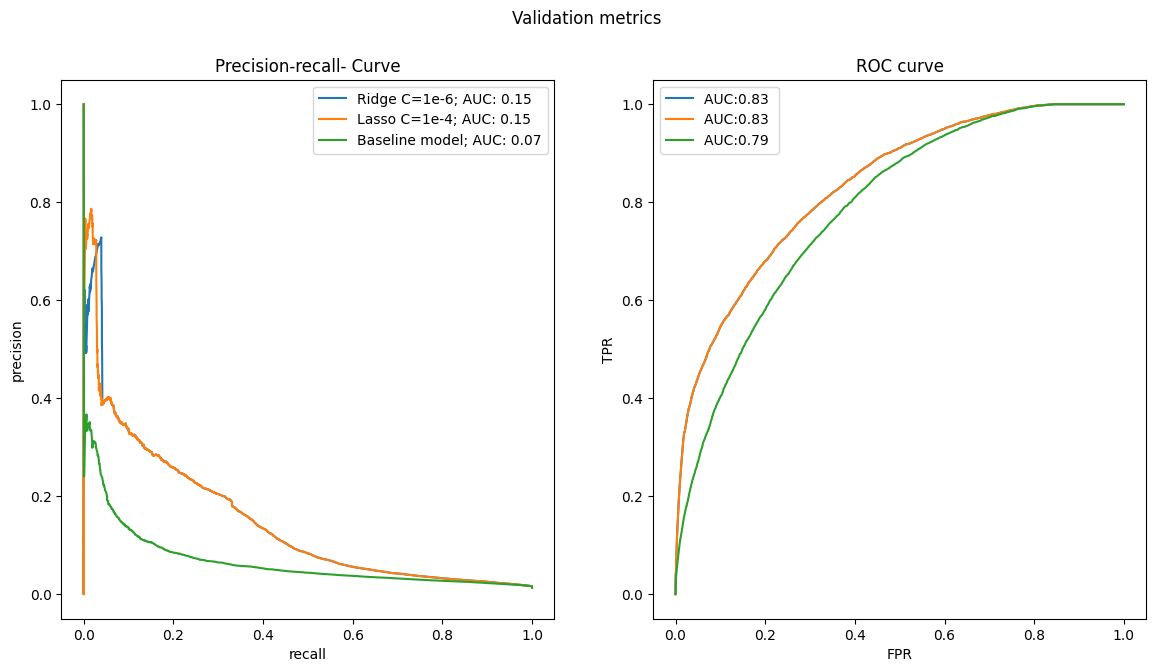

In [130]:
fig1, ax1 = plt.subplots(1,2, figsize=(14, 7 ))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1,2, figsize=(14, 7 ))
fig2.suptitle("Validation metrics")

names = ["Ridge C=1e-6", "Lasso C=1e-4"]
lrs = [
    make_pipeline(StandardScaler(), LogisticRegression(penalty="l2", C=1e-6)),
    make_pipeline(StandardScaler(), LogisticRegression(penalty="l1", C=1e-4, solver="saga"))
]

for name, lr in zip(names, lrs):
    lr.fit(X_train[new_train_cols], y_train)
    train_proba = lr.predict_proba(X_train[new_train_cols])[:, 1]
    plot_metrics(
        name, y_pred=train_proba, y_test=y_train, figure=(fig1, ax1)
    )

    val_proba = lr.predict_proba(X_val[new_train_cols])[:, 1]
    plot_metrics(
        name, y_pred=val_proba, y_test=y_val, figure=(fig2, ax2)
    ) 

plot_metrics(
    f"Baseline model",
    y_pred=val_df["global_popularity"],
    y_test=val_df[label_col],
    figure=(fig2, ax2)
)   
    

A priori, no se ve mucha diferencia entre usar Ridge o Lasso con las 3 variables con más "importancia".